In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
# calculate class weights based on the training data

In [2]:
test = pd.read_parquet('/Users/natalie/Desktop/DS Thesis/Code/data/test.parquet')
train = pd.read_parquet('/Users/natalie/Desktop/DS Thesis/Code/data/train.parquet')

In [3]:
TARGET ='churn_user'
CATEGORICAL_FEATURES  = ['os_name', 'age_group','gender', 'country', 'region', 'province_type',
                         'province']
DATETIME_FEATURES  = ['first_date', 'lastest_active_day']
SEARCH_CC_FEATURES = [ 'clicks', 'search_volume', 'dating_search', 'videoclip_search', 'technical_search', 'housekeeping_family_search', 'marketing_search', 'other_search']
SEARCH_GG_FEATURES = [   'serp_click', 'search_volume_gg', 'search_clicks_gg', 'other_search_gg','housekeeping_family_search_gg','videoclip_search_gg', 'dating_search_gg', 'marketing_search_gg', 'technical_search_gg']
ACTIVE_FEATURES = ['active_day', 'life_time',  'not_active_day', 'total_active_time']
ADS_FEATURES =  ['ads_impression', 'ads_click', 'ads_revenue']
OTHERS_FEATURES =[                      'newtab_count', 'download_count', 'pip_count', 'sidebar_count', 'incognito_count', 'signin_count', 'youtube_count',
                    'work_count', 'social_count', 'news_count', 'entertainment_count', 'ecommerce_count']
NUMERICAL_FEATURES = SEARCH_CC_FEATURES + SEARCH_GG_FEATURES + ACTIVE_FEATURES + ADS_FEATURES + OTHERS_FEATURES

MODEL_NAMES = ['log_reg', 'randomforest','lightgbm', 'xgboost']


In [4]:
def find_best_threshold_f1_score(train_labels, oofs, average='macro'):
    scores = []
    thresholds = []
    best_score = 0
    best_threshold = 0
    for threshold in np.arange(0.1, 0.9, 0.01):
        print(f'{threshold:.02f}, ', end='')
        preds = (oofs > threshold).astype('int')
        m = f1_score(train_labels, preds, average=average)
        scores.append(m)
        thresholds.append(threshold)
        if m > best_score:
            best_score = m
            best_threshold = threshold
    return best_threshold, best_score


In [22]:
def flat_feature_engineer(df):
    temp = pd.DataFrame()
    temp['OTHERS_FEATURES_SUM'] = df[OTHERS_FEATURES].sum(axis=1)
    temp['OTHERS_FEATURES_MIN'] = df[OTHERS_FEATURES].min(axis=1)
    temp['OTHERS_FEATURES_MAX'] = df[OTHERS_FEATURES].max(axis=1)
    temp['OTHERS_FEATURES_MEAN'] = df[OTHERS_FEATURES].mean(axis=1)
    temp['ADS_CTR'] = df['ads_click'] / df['ads_impression']
    temp['SEARCH_CC_FEATURES_SUM'] = df[SEARCH_CC_FEATURES[1:]].sum(axis=1)
    temp['SEARCH_CC_FEATURES_MIN'] = df[SEARCH_CC_FEATURES[1:]].min(axis=1)
    temp['SEARCH_CC_FEATURES_MAX'] = df[SEARCH_CC_FEATURES[1:]].max(axis=1)
    temp['SEARCH_CC_FEATURES_MEAN'] = df[SEARCH_CC_FEATURES[1:]].mean(axis=1)
    temp['SEARCH_GG_FEATURES_SUM'] = df[SEARCH_GG_FEATURES[1:]].sum(axis=1)
    temp['SEARCH_GG_FEATURES_MIN'] = df[SEARCH_GG_FEATURES[1:]].min(axis=1)
    temp['SEARCH_GG_FEATURES_MAX'] = df[SEARCH_GG_FEATURES[1:]].max(axis=1)
    temp['SEARCH_GG_FEATURES_MEAN'] = df[SEARCH_GG_FEATURES[1:]].mean(axis=1)
    temp['not_active_day_per_active_day'] = df['not_active_day'] / df['active_day']
    temp['life_time_per_active_day'] = df['life_time'] / df['active_day']
    return temp, list(temp.columns)

def fillna(df):
    df['total_active_time'] = df['total_active_time'].fillna(0)
    df['ads_impression'] = df['ads_impression'].fillna(0)
    df['ads_click'] = df['ads_click'].fillna(0)
    df['ads_revenue'] = df['ads_revenue'].fillna(0)
    df['clicks'] = df['clicks'].fillna(0)
    for c in OTHERS_FEATURES:
        df[c] = df[c].fillna(0)
    return df

def process_data(df,oh_encoder=None,agg_features=None):
    if not oh_encoder:
        print("fit train")
        oh_encoder = OneHotEncoder()
        oh_encoder.fit(df[CATEGORICAL_FEATURES])
    else:
        print("loadd onehot encoder")
    df_cat = pd.DataFrame(oh_encoder.transform(df[CATEGORICAL_FEATURES]).toarray())
    new_cat = oh_encoder.get_feature_names_out(CATEGORICAL_FEATURES)
    df_cat.columns = new_cat
    new_df = pd.concat([df_cat.reset_index(drop=True), df[NUMERICAL_FEATURES].reset_index(drop=True)], axis=1)
    new_df = fillna(new_df)
    return new_df, oh_encoder

In [7]:
N_ESTIMATORS = 2
SEED=42
LGBM_Hyperparameters =  {
    "n_estimators": N_ESTIMATORS,
    'learning_rate':0.03,
     'max_depth':8,
     'colsample_bytree':0.8,
     'subsample':0.8,
     # 'reg_alpha':8,
     # 'reg_lambda':32,

    "random_state":SEED,
    'device':'gpu',
#     "class_weight": "balanced"
}

XGBoost_Hyperparameters = {
    'objective' : 'binary:logistic',
     'eval_metric':['logloss', 'auc'],
     'n_estimators':N_ESTIMATORS,
     'learning_rate':0.03,
     'max_depth':8,
     'colsample_bytree':0.5,
     'subsample':0.8,
     'reg_alpha':8,
     'reg_lambda':32,
     'seed':SEED,
     # 'scale_pos_weight':3,
     'enable_categorical':True,
     'early_stopping_rounds': 50,
     'tree_method':'gpu_hist'}
RF_Hyperparameters = {
    'n_estimators': N_ESTIMATORS,
    'max_depth':8,
    'random_state':SEED,
    'max_features': 'sqrt', 
    'n_jobs': -1
}
Logreg_Hyperparameters = {'max_iter':N_ESTIMATORS,'random_state':SEED} 
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

def cross_validate(train, USE_SMOTE=False, USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    oofs = np.zeros((train.shape[0], 4))
    for i, (train_index, valid_index) in enumerate(kfold.split(train, train[TARGET])):
        print(f"===========fold {i}================")
        X_train, oh_encoder = process_data(train.iloc[train_index])
        X_valid, _  = process_data(train.iloc[valid_index], oh_encoder)
        print(X_train.isnull().sum())
        y_train = train.iloc[train_index][TARGET].values
        y_valid = train.iloc[valid_index][TARGET].values
        logreg_hyperparameters = Logreg_Hyperparameters.copy()
        lgb_hyperparameters = LGBM_Hyperparameters.copy()
        xgboost_hyperparameters = XGBoost_Hyperparameters.copy()
        rf_hyperparameters = RF_Hyperparameters.copy()
        if USE_SMOTE:
            print("SMOTEEEE")
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
        elif USE_CLASS_WEIGHT:
            print("CLASS_WEIGHTTTT")
           
            class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
            class_weights =  {0: class_weights[0], 1: class_weights[1]}
            lgb_hyperparameters['class_weight'] = class_weights
            logreg_hyperparameters['class_weight'] = class_weights
            xgboost_hyperparameters['class_weght'] = class_weights 
            rf_hyperparameters['class_weight'] = class_weights
        elif USE_UNDER_SAMPLING:
            print("UNDER SAMPLING")
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
        print("LOGREG--------------")
        logreg_model = LogisticRegression(**logreg_hyperparameters)
        logreg_model.fit(X_train, y_train)
        logreg_y_pred_proba = logreg_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, logreg_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in logreg_y_pred_proba]

        print(roc_auc_score(y_valid, logreg_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,0] = logreg_y_pred_proba

        print("Random Forest--------------")
        rf_model = RandomForestClassifier(**rf_hyperparameters)
        rf_model.fit(X_train, y_train)
        rf_y_pred_proba = rf_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, rf_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in rf_y_pred_proba]

        print(roc_auc_score(y_valid, rf_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,1] = rf_y_pred_proba
    #     models.append(model)
        print("LGBModel--------------")
        lgb_model = LGBMClassifier(**lgb_hyperparameters)
        callbacks = [lgb.early_stopping(200, verbose=50), lgb.log_evaluation(period=50)]
        lgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric=["logloss", "auc"],
                  callbacks=callbacks)

        lgb_y_pred_proba = lgb_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, lgb_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in lgb_y_pred_proba]
        print(roc_auc_score(y_valid, lgb_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,2] = lgb_y_pred_proba
    #     models.append(model)
        display(pd.DataFrame({'score': lgb_model.feature_importances_, 'feature': lgb_model.feature_name_}).sort_values('score',ascending=False))

        print("XGBoost--------------")
        xgb_model = XGBClassifier(**xgboost_hyperparameters)
        xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=50)
        xgb_y_pred_proba = xgb_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, xgb_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in xgb_y_pred_proba]
        print(roc_auc_score(y_valid, xgb_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index, 3] = xgb_y_pred_proba
    return oofs

In [8]:
from sklearn.metrics import confusion_matrix
accuracy_scores = []
f1_scores = []
auc_scores = []
specificity_scores = []
sensitivity_scores = []
def scoring(y_test,y_pred_proba, best_threshold):
    y_pred = [1 if y_hat >= best_threshold else 0 for y_hat in y_pred_proba]
    acc = accuracy_score(y_test, y_pred)
    _f1_score = f1_score(y_test, y_pred, average='macro')
    auc_score = roc_auc_score(y_test, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    print("accuracy", acc)
    print("f1_score", _f1_score)
    print("auc", auc_score)
    print("sensitivity", sensitivity, "specificity", specificity)
    print(classification_report(y_test, y_pred, digits=4))
    return acc, _f1_score, auc_score, specificity, sensitivity

In [15]:
#     NEW_FEATURES = []
# X_train_temp, NEW_FEATURES  = feature_engineer(X_train)
# X_valid_temp,_ = feature_engineer(X_valid)
# X_train = pd.concat([X_train, X_train_temp], axis=1)
# X_valid = pd.concat([X_valid, X_valid_temp], axis=1)
# province_not_active_day = X_train.groupby("province")["not_active_day"].mean()
# X_train['province_not_active_day'] = X_train['province'].map(province_not_active_day)
# X_valid['province_not_active_day'] = X_valid['province'].map(province_not_active_day)
# NEW_FEATURES.append('province_not_active_day')

def train_model(oofs,X_train, y_train, X_test, y_test, USE_SMOTE=False,USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    models = []
    predictions = []
    accuracy_scores = []
    f1_scores = []
    auc_scores = []
    specificity_scores = []
    sensitivity_scores = []
    best_thresholds = []
    for i in range(4):
        best_threshold, best_score = find_best_threshold_f1_score(train[TARGET].values, oofs[:,i])
        best_thresholds.append(best_threshold)
    logreg_hyperparameters = Logreg_Hyperparameters.copy()
    lgb_hyperparameters = LGBM_Hyperparameters.copy()
    xgboost_hyperparameters = XGBoost_Hyperparameters.copy()
    del xgboost_hyperparameters['early_stopping_rounds']
    rf_hyperparameters = RF_Hyperparameters.copy()
    if USE_SMOTE:
        print("SMOTEEEE")
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    elif USE_CLASS_WEIGHT:
        print("CLASS_WEIGHTTTT")
        class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
        class_weights =  {0: class_weights[0], 1: class_weights[1]}
        lgb_hyperparameters['class_weight'] = class_weights
        logreg_hyperparameters['class_weight'] = class_weights
        xgboost_hyperparameters['class_weght'] = class_weights 
        rf_hyperparameters['class_weight'] = class_weights
    elif USE_UNDER_SAMPLING:
        print("UNDER SAMPLING")
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)

    print("LOGREG--------------")
    logreg_model = LogisticRegression(**logreg_hyperparameters)
    logreg_model.fit(X_train, y_train)
    logreg_y_pred_proba = logreg_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,logreg_y_pred_proba,best_thresholds[0])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(logreg_y_pred_proba)
    models.append(logreg_model)

    print("Random Forest--------------")
    rf_model = RandomForestClassifier(**rf_hyperparameters)
    rf_model.fit(X_train, y_train)
    rf_y_pred_proba = rf_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,rf_y_pred_proba,best_thresholds[1])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(rf_y_pred_proba)
    models.append(rf_model)

    print("LGBModel--------------")
    lgb_model = LGBMClassifier(**lgb_hyperparameters)
    lgb_model.fit(X_train, y_train)
    lgb_y_pred_proba = lgb_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,lgb_y_pred_proba,best_thresholds[2])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(lgb_y_pred_proba)
    models.append(lgb_model)

    print("XGBoost--------------")
    xgb_model = XGBClassifier(**xgboost_hyperparameters)
    xgb_model.fit(X_train, y_train)
    xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,xgb_y_pred_proba,best_thresholds[3])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    
    print(MODEL_NAMES)
    print(accuracy_scores)
    print(f1_scores)
    print(auc_scores)
    print(specificity_scores)
    print(sensitivity_scores)

    predictions.append(xgb_y_pred_proba)
    models.append(xgb_model)

    score_df = pd.DataFrame({'model_name': MODEL_NAMES,
                         'accuracy_score':accuracy_scores, 
                         'f1_score': f1_scores, 
                         'auc_score': auc_scores, 
                         'specificity_score': specificity_scores, 
                         'sensitivity_score': sensitivity_scores})
    return score_df,models, predictions

In [16]:
X_train,oh_encoder = process_data(train)
X_test, _ = process_data(test,oh_encoder)
y_train = train[TARGET].values
y_test = test[TARGET].values

fit train
loadd onehot encoder


In [ ]:
N_ESTIMATORS = 200
print("Not handle Balanced")
nothing_oofs = cross_validate(train)
nothing_score_df, nothing_models, nothing_predictions = train_model(nothing_oofs,X_train, y_train, X_test, y_test)

print("Use SMOTE")
smote_oofs = cross_validate(train, USE_SMOTE=True)
smote_score_df, smote_models, smote_predictions = train_model(smote_oofs,X_train, y_train, X_test, y_test, USE_SMOTE=True)

print("Use Class weight")
class_weight_oofs = cross_validate(train, USE_CLASS_WEIGHT=True)
class_weight_score_df, class_weight_models, class_weight_predictions = train_model(class_weight_oofs,X_train, y_train, X_test, y_test, USE_CLASS_WEIGHT=True)

print("Use Under sampling")
under_sampling_oofs = cross_validate(train, USE_UNDER_SAMPLING=True)
under_sampling_score_df, under_sampling_models, under_sampling_predictions = train_model(under_sampling_oofs,X_train, y_train, X_test, y_test, USE_UNDER_SAMPLING=True)

In [26]:
under_sampling_score_df

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,log_reg,0.733885,0.674145,0.781647,0.769199,0.624842
1,randomforest,0.818225,0.767681,0.885701,0.850351,0.719025
2,lightgbm,0.831685,0.779012,0.894293,0.873678,0.702019
3,xgboost,0.828145,0.769858,0.891376,0.881290,0.664044


In [30]:
import pickle

In [44]:
with open(f"/Users/natalie/Desktop/DS Thesis/Code/checkpoints/nothing_model_{N_ESTIMATORS}_estimators.pkl", "wb") as f:
    pickle.dump({
        "score_df": nothing_score_df,
        "oofs": nothing_oofs,
        "models": nothing_models,
        "model_names": MODEL_NAMES,
        "predictions":nothing_predictions},f,protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f"/Users/natalie/Desktop/DS Thesis/Code/checkpoints/smote_model_{N_ESTIMATORS}_estimators.pkl", "wb") as f:
    pickle.dump({
            "score_df":smote_score_df,
            "oofs": smote_oofs,
            "models": smote_models,
            "model_names": MODEL_NAMES,
            "predictions":smote_predictions},f,protocol=pickle.HIGHEST_PROTOCOL)    

with open(f"/Users/natalie/Desktop/DS Thesis/Code/checkpoints/class_weight_model_{N_ESTIMATORS}_estimators.pkl", "wb") as f:
    pickle.dump({
            "score_df":class_weight_score_df,
            "oofs": class_weight_oofs,
            "models": class_weight_models,
            "model_names": MODEL_NAMES,
            "predictions":class_weight_predictions},f,protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f"/Users/natalie/Desktop/DS Thesis/Code/checkpoints/under_sampling_model_{N_ESTIMATORS}_estimators.pkl", "wb") as f:
    pickle.dump({
            "score_df":under_sampling_score_df,
            "oofs": under_sampling_oofs,
            "models": under_sampling_models,
            "model_names": MODEL_NAMES,
            "predictions":under_sampling_predictions},f,protocol=pickle.HIGHEST_PROTOCOL)



In [140]:
x0 = nothing_score_df[under_sampling_score_df.model_name=='lightgbm']
x0['method'] = 'not_handle'
x1 = smote_score_df[smote_score_df.model_name=='lightgbm']
x1['method'] = 'smote'
x2 = class_weight_score_df[class_weight_score_df.model_name=='lightgbm']
x2['method'] = 'class_weight'
x3 = under_sampling_score_df[under_sampling_score_df.model_name=='lightgbm']
x3['method'] = 'under_sampling' 

In [ ]:
lightgbm_scores = pd.concat([x0, x1, x2, x3])


In [129]:
lightgbm_scores.columns[1:-1]

Index(['accuracy_score', 'f1_score', 'auc_score', 'specificity_score',
       'sensitivity_score'],
      dtype='object')

In [141]:
lightgbm_scores = pd.concat([x0, x1, x2, x3])
lightgbm_scores['accuracy_score'].values

array([0.83565 , 0.83326 , 0.835085, 0.834865])

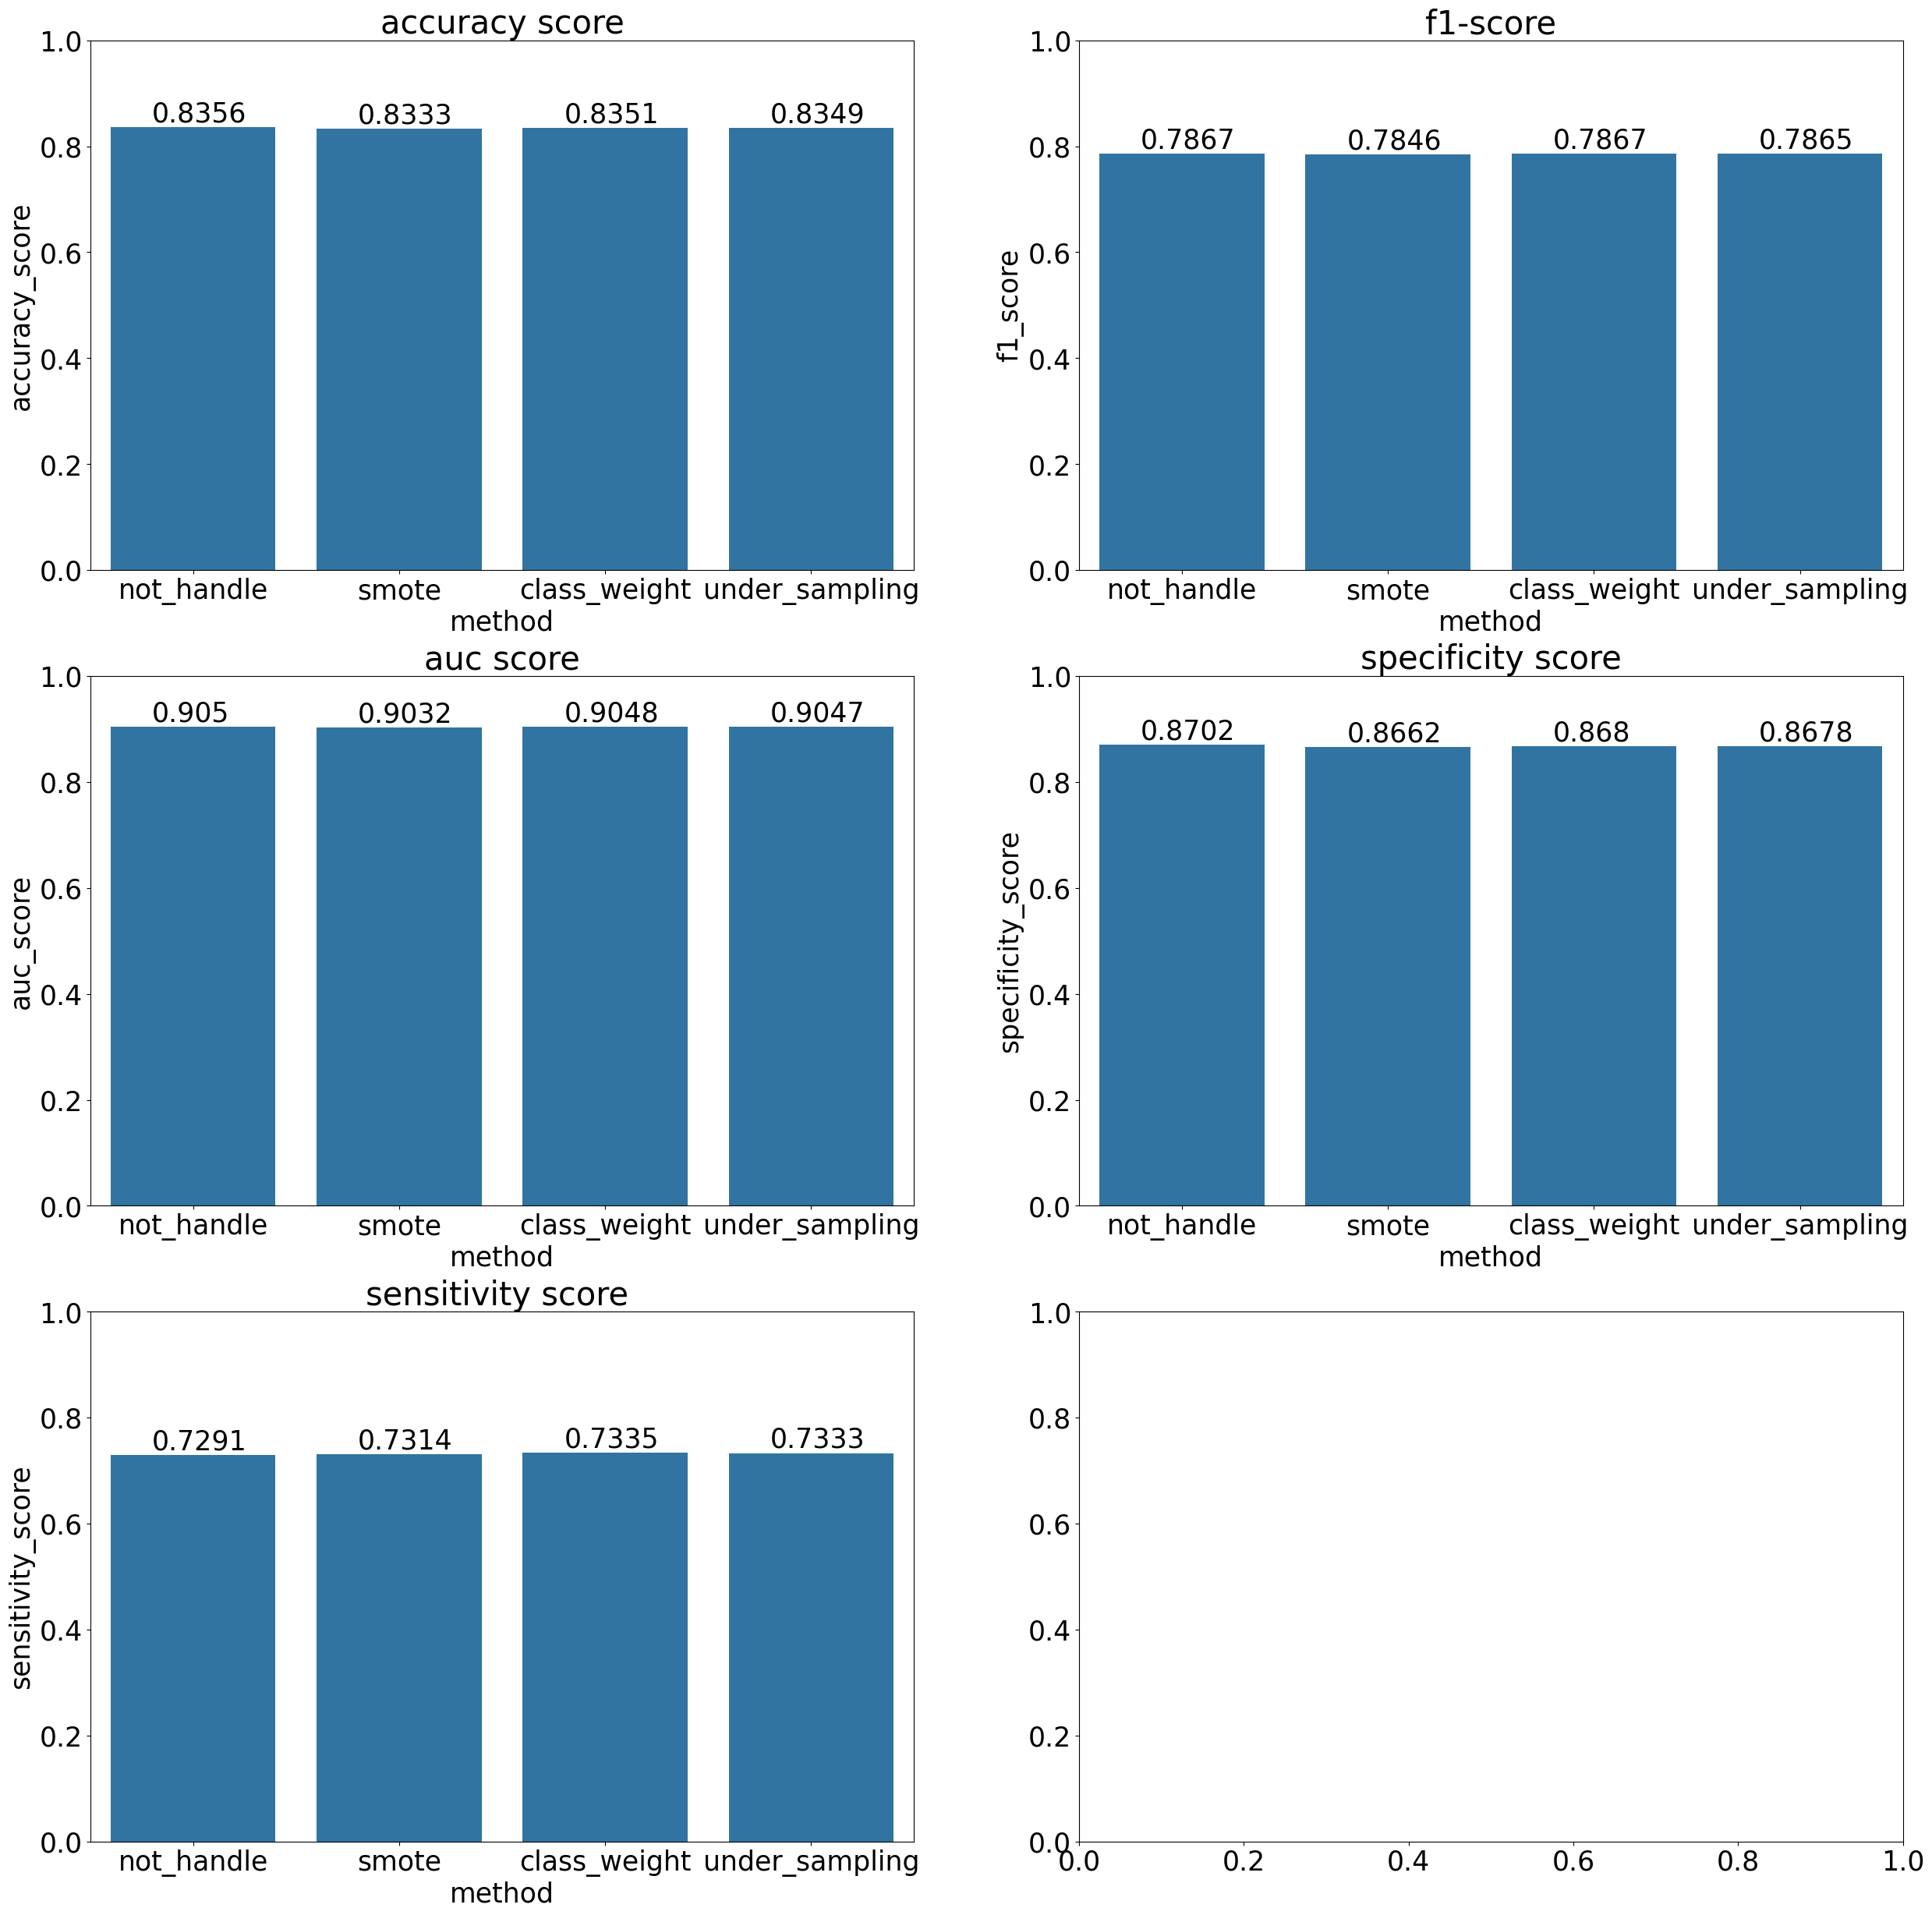

In [142]:
import matplotlib
font = {'size'   : 25}

matplotlib.rc('font', **font)
fig, axes = plt.subplots(3, 2, figsize=(30,30))
sns.barplot(x='method', y='accuracy_score', data=lightgbm_scores, ax=axes[0,0])
for i, val in enumerate(lightgbm_scores['accuracy_score'].values):
    axes[0,0].text(i-0.2, val+0.01, round(val, 4))
axes[0,0].set_ylim(0,1)
axes[0,0].set_title("accuracy score")

sns.barplot(x='method', y='f1_score', data=lightgbm_scores, ax=axes[0,1])
for i, val in enumerate(lightgbm_scores['f1_score'].values):
    axes[0,1].text(i-0.2, val+0.01, round(val, 4))
axes[0,1].set_ylim(0,1)
axes[0,1].set_title("f1-score")

sns.barplot(x='method', y='auc_score', data=lightgbm_scores, ax=axes[1,0])
for i, val in enumerate(lightgbm_scores['auc_score'].values):
    axes[1,0].text(i-0.2, val+0.01, round(val, 4))
axes[1,0].set_ylim(0,1)
axes[1,0].set_title("auc score")

sns.barplot(x='method', y='specificity_score', data=lightgbm_scores, ax=axes[1,1])
for i, val in enumerate(lightgbm_scores['specificity_score'].values):
    axes[1,1].text(i-0.2, val+0.01, round(val, 4))
axes[1,1].set_ylim(0,1)
axes[1,1].set_title("specificity score")

sns.barplot(x='method', y='sensitivity_score', data=lightgbm_scores, ax=axes[2,0])
for i, val in enumerate(lightgbm_scores['sensitivity_score'].values):
    axes[2, 0].text(i-0.2, val+0.01, round(val, 4))
axes[2, 0].set_ylim(0,1)
axes[2, 0].set_title("sensitivity score ")

plt.show()

In [139]:
nothing_score_df.to_csv("/Users/natalie/Desktop/DS Thesis/Code/outputs/nothing_score_df.csv", index=False)
smote_score_df.to_csv("/Users/natalie/Desktop/DS Thesis/Code/outputs/smote_score_df.csv", index=False)
class_weight_score_df.to_csv("/Users/natalie/Desktop/DS Thesis/Code/outputs/class_weight_score_df.csv", index=False)
under_sampling_score_df.to_csv("/Users/natalie/Desktop/DS Thesis/Code/outputs/class_weight_score_df.csv", index=False)